In [1]:
%matplotlib inline
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib
from sklearn.decomposition import PCA
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
# !rm -rf /workspaces/major_project/code/runs


2024-01-04 02:20:36.434524: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-04 02:20:36.764933: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-04 02:20:36.765401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-04 02:20:36.829100: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-04 02:20:36.966944: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-04 02:20:36.971180: I tensorflow/core/platform/cpu_feature_guard.cc:1

# Model creation

In [2]:
import torch
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.lstm3 = nn.LSTM(hidden_size2, hidden_size3, batch_first=True)
        self.dropout3 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_size3, 50)
        self.dropout4 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)
        out = self.dropout2(out)
        out, _ = self.lstm3(out)
        out = self.dropout3(out)
        out = out[:, -1, :]
        out = torch.relu(self.fc1(out))
        out = self.dropout4(out)
        out = self.sigmoid(self.fc2(out))
        return out


class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(GRUModel, self).__init__()
        self.gru1 = nn.GRU(input_size, hidden_size1, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.gru2 = nn.GRU(hidden_size1, hidden_size2, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.gru3 = nn.GRU(hidden_size2, hidden_size3, batch_first=True)
        self.dropout3 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_size3, 50)
        self.dropout4 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.reshape(-1, 1, 7) # Reshape input to have last dim of 7
        out, _ = self.gru1(x)
        out = self.dropout1(out)
        out, _ = self.gru2(out)
        out = self.dropout2(out)
        out, _ = self.gru3(out)
        out = self.dropout3(out)
        out = out[:, -1, :]
        out = torch.relu(self.fc1(out))
        out = self.dropout4(out)
        out = self.sigmoid(self.fc2(out))
        return out


class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(RNNModel, self).__init__()
        self.rnn1 = nn.RNN(input_size, hidden_size1, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.rnn2 = nn.RNN(hidden_size1, hidden_size2, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.rnn3 = nn.RNN(hidden_size2, hidden_size3, batch_first=True)
        self.dropout3 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_size3, 50)
        self.dropout4 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.reshape(-1, 1, 7) # Reshape input to have last dim of 7
        out, _ = self.rnn1(x)
        out = self.dropout1(out)
        out, _ = self.rnn2(out)
        out = self.dropout2(out)
        out, _ = self.rnn3(out)
        out = self.dropout3(out)
        out = out[:, -1, :]
        out = torch.relu(self.fc1(out))
        out = self.dropout4(out)
        out = self.sigmoid(self.fc2(out))
        return out

import torch.nn as nn
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(TransformerModel, self).__init__()
        self.transformer = nn.Transformer(d_model=input_size, nhead=7, num_encoder_layers=2, num_decoder_layers=2)
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.dropout3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(hidden_size3, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.reshape(-1, 1, 7)  # Reshape input to have last dim of 7
        out = self.transformer(x, x)
        out = out[:, -1, :]
        out = torch.relu(self.fc1(out))
        out = self.dropout1(out)
        out = torch.relu(self.fc2(out))
        out = self.dropout2(out)
        out = torch.relu(self.fc3(out))
        out = self.dropout3(out)
        out = self.sigmoid(self.fc4(out))
        return out


DLMODEL = GRUModel

# NIDS dataset setup

In [3]:
X_train = pd.read_csv("../ids-dataset/network/trainset.csv")
X_test = pd.read_csv("../ids-dataset/network/testset.csv")
y_train = pd.read_csv("../ids-dataset/network/trainlabel.csv")
y_test = pd.read_csv("../ids-dataset/network/testlabel.csv")


X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train = X_train.values
X_test = X_test.values
X_val = X_val.values
y_train = y_train.values.flatten()
y_test = y_test.values.flatten()
y_val = y_val.values.flatten()

# Normalize the data using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

pca = PCA(n_components=7)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
X_val = pca.transform(X_val)

# Convert data to PyTorch tensors
network_X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
network_y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
network_X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
network_y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
network_X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
network_y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


# PE file dataset setup

In [4]:
# /home/mani/Desktop/main_project/data/csv/pe_data.csv
pe_data = pd.read_csv('../data/csv/pe_data_revision2.csv')

X = pe_data.drop(['Name', 'Label'], axis=1)
y = pe_data['Label']

# split the data into train, test and validation sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

X_train = X_train.values
X_test = X_test.values
X_val = X_val.values
y_train = y_train.values.flatten()
y_test = y_test.values.flatten()
y_val = y_val.values.flatten()

# Normalize the data using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# pca = PCA(n_components=7)

# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)
# X_val = pca.transform(X_val)

# Convert data to PyTorch tensors
pe_X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
pe_y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
pe_X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
pe_y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
pe_X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
pe_y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

Implementation of Individual Datasets With RNN

In [7]:
input_size = X_train.shape[1]  # Update to the correct input size
hidden_size1 = 100
hidden_size2 = 50
hidden_size3 = 25
output_size = 1


model = DLMODEL(input_size, hidden_size1, hidden_size2,
                  hidden_size3, output_size)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

NIDS dataset training WITH RNN

In [ ]:
writer = SummaryWriter('Packet files with RNN')

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 30
batch_size = 32


# Create TensorDatasets
train_dataset = TensorDataset(network_X_train_tensor, network_y_train_tensor)
test_dataset = TensorDataset(network_X_test_tensor, network_y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


patience = 3  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')  # Best validation loss seen so far
epochs_without_improvement = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0

    pbar = tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', dynamic_ncols=True, unit=' steps')

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(2))
        loss = criterion(outputs, labels.unsqueeze(1))  # Adjust labels dimension
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct_train += torch.sum((outputs > 0.5).float() == labels.unsqueeze(1))

        # pbar.set_postfix({'Loss': running_loss / ((i/batch_size) + 1)})
        pbar.update()

    average_loss = running_loss / len(train_loader)
    accuracy = correct_train.item() / len(network_X_train_tensor)

    # Validation
    model.eval()
    val_outputs = model(network_X_test_tensor.unsqueeze(2))
    val_loss = criterion(val_outputs, network_y_test_tensor.unsqueeze(1))
    correct_val = torch.sum((val_outputs > 0.5).float() == network_y_test_tensor.unsqueeze(1))
    val_accuracy = correct_val.item() / len(network_X_test_tensor)
    
    writer.add_scalar('Training Loss Comparision', average_loss, epoch)
    writer.add_scalar('Training Accuracy Comparision', accuracy, epoch)
    writer.add_scalar('Testing Loss Comparision', val_loss.item(), epoch)
    writer.add_scalar('Testing Accuracy Comparision', val_accuracy, epoch)

    pbar.set_postfix({'Epoch': epoch + 1, 'Loss': average_loss, 'Accuracy': accuracy, 'Validation Loss': val_loss.item(), 'Validation Accuracy': val_accuracy})
    pbar.close()

    # Store metrics
    train_losses.append(average_loss)
    train_accuracies.append(accuracy)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy)
    
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    # If there has been no improvement for `patience` epochs, stop training
    if epochs_without_improvement >= patience:
        print(f'Early stopping after {epoch+1} epochs')
        break
    

writer.close()
# Plot the metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs for Packetfiles with RNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Over Epochs for Packetfiles with RNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Epoch 7/30:  19%|█▉        | 486/2507 [00:25<00:21, 93.27 steps/s]

PE file dataset training with RNN

In [ ]:
writer = SummaryWriter('PE Files with RNN')

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 30
batch_size = 32

# Create TensorDatasets
train_dataset = TensorDataset(pe_X_train_tensor, pe_y_train_tensor)
test_dataset = TensorDataset(pe_X_test_tensor, pe_y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0

    pbar = tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', dynamic_ncols=True, unit=' steps')

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(2)) 
        loss = criterion(outputs, labels.unsqueeze(1))  # Adjust labels dimension
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct_train += torch.sum((outputs > 0.5).float() == labels.unsqueeze(1))

        # pbar.set_postfix({'Loss': running_loss / ((i/batch_size) + 1)})
        pbar.update()

    average_loss = running_loss / len(train_loader)
    accuracy = correct_train.item() / len(pe_X_train_tensor)

    # Validation
    model.eval()
    val_outputs = model(pe_X_test_tensor.unsqueeze(2))
    val_loss = criterion(val_outputs, pe_y_test_tensor.unsqueeze(1))
    correct_val = torch.sum((val_outputs > 0.5).float() == pe_y_test_tensor.unsqueeze(1))
    val_accuracy = correct_val.item() / len(pe_X_test_tensor)

    pbar.set_postfix({'Epoch': epoch + 1, 'Loss': average_loss, 'Accuracy': accuracy, 'Validation Loss': val_loss.item(), 'Validation Accuracy': val_accuracy})
    pbar.close()
    
    writer.add_scalar('Training Loss Comparision', average_loss, epoch)
    writer.add_scalar('Training Accuracy Comparision', accuracy, epoch)
    writer.add_scalar('Testing Loss Comparision', val_loss.item(), epoch)
    writer.add_scalar('Testing Accuracy Comparision', val_accuracy, epoch)
    
    # Store metrics
    train_losses.append(average_loss)
    train_accuracies.append(accuracy)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy)

# Plot the metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs for PE Files with RNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Over Epochs for PE Files with RNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Training both datasets together with RNN

In [5]:
input_size = X_train.shape[1]  # Update to the correct input size
hidden_size1 = 100
hidden_size2 = 50
hidden_size3 = 25
output_size = 1

model = DLMODEL(input_size, hidden_size1, hidden_size2,
                  hidden_size3, output_size)

# traing the model with both the datasets
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)




Epoch 1/30:   0%|          | 0/2730 [00:00<?, ? steps/s]

Epoch 30/30: 100%|██████████| 2730/2730 [00:16<00:00, 163.82 steps/s, Epoch=30, Loss1=0.312, Accuracy1=0.93, Loss2=0.0301, Accuracy2=0.992, Validation Loss=0.207, Validation Accuracy=0.954]


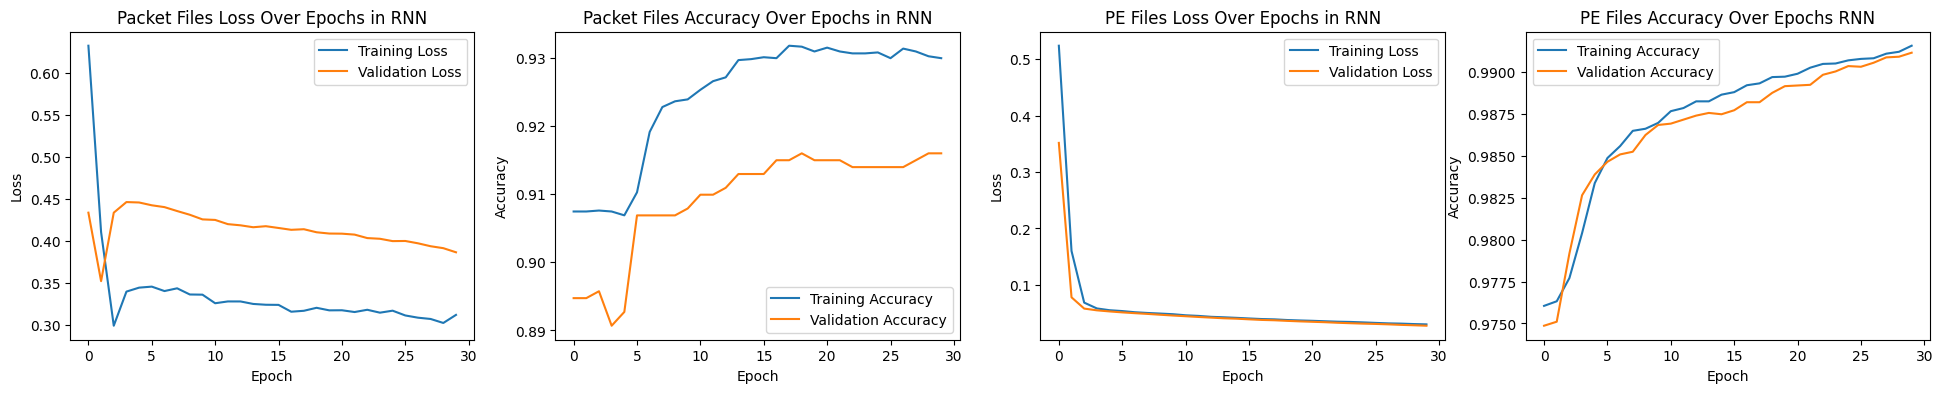

In [6]:
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# pe_X_train_tensor, pe_y_train_tensor, pe_X_test_tensor, pe_y_test_tensor are  first datasets
# network_X_train_tensor, network_y_train_tensor, network_X_test_tensor, network_y_test_tensor are  second datasets

writer = SummaryWriter('RNN MULTIMODEL')

train_losses1, train_losses2 = [], []
train_accuracies1, train_accuracies2 = [], []
val_losses1, val_losses2 = [], []
val_accuracies1, val_accuracies2 = [], []

num_epochs = 30
batch_size = 32

# Create TensorDatasets
train_dataset1 = TensorDataset(pe_X_train_tensor, pe_y_train_tensor)
test_dataset1 = TensorDataset(pe_X_test_tensor, pe_y_test_tensor)

train_dataset2 = TensorDataset(network_X_train_tensor, network_y_train_tensor)
test_dataset2 = TensorDataset(network_X_test_tensor, network_y_test_tensor)

# Create DataLoaders
train_loader1 = DataLoader(train_dataset1, batch_size=batch_size, shuffle=True)
test_loader1 = DataLoader(test_dataset1, batch_size=batch_size, shuffle=False)

train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)
test_loader2 = DataLoader(test_dataset2, batch_size=batch_size, shuffle=False)


for epoch in range(num_epochs):
    model.train()
    running_loss1, running_loss2 = 0.0, 0.0
    correct_train1, correct_train2 = 0, 0

    pbar = tqdm(total=len(train_loader1) + len(train_loader2), desc=f'Epoch {epoch+1}/{num_epochs}', dynamic_ncols=True, unit=' steps')

    # Iterate over first dataloader
    for inputs1, labels1 in train_loader1:
        optimizer.zero_grad()
        
        # Train on first dataset
        outputs1 = model(inputs1.unsqueeze(2))
        loss1 = criterion(outputs1, labels1.unsqueeze(1))  # Adjust labels dimension
        loss1.backward()
        optimizer.step()

        running_loss1 += loss1.item()
        correct_train1 += torch.sum((outputs1 > 0.5).float() == labels1.unsqueeze(1))

        pbar.update()

    # Iterate over second dataloader
    for inputs2, labels2 in train_loader2:
        optimizer.zero_grad()

        # Train on second dataset
        outputs2 = model(inputs2.unsqueeze(2))
        loss2 = criterion(outputs2, labels2.unsqueeze(1))  # Adjust labels dimension
        loss2.backward()
        optimizer.step()

        running_loss2 += loss2.item()
        correct_train2 += torch.sum((outputs2 > 0.5).float() == labels2.unsqueeze(1))

        pbar.update()

    average_loss1 = running_loss1 / len(train_loader1)
    accuracy1 = correct_train1.item() / len(pe_X_train_tensor)

    average_loss2 = running_loss2 / len(train_loader2)
    accuracy2 = correct_train2.item() / len(network_X_train_tensor)

    
    # Validation
    model.eval()
    val_outputs1 = model(pe_X_test_tensor.unsqueeze(2))
    val_loss1 = criterion(val_outputs1, pe_y_test_tensor.unsqueeze(1))
    correct_val1 = torch.sum((val_outputs1 > 0.5).float() == pe_y_test_tensor.unsqueeze(1))

    val_outputs2 = model(network_X_test_tensor.unsqueeze(2))
    val_loss2 = criterion(val_outputs2, network_y_test_tensor.unsqueeze(1))
    correct_val2 = torch.sum((val_outputs2 > 0.5).float() == network_y_test_tensor.unsqueeze(1))

    val_loss = (val_loss1.item() + val_loss2.item()) / 2
    val_accuracy1 = correct_val1.item() / len(pe_X_test_tensor)
    val_accuracy2 = correct_val2.item() / len(network_X_test_tensor)

    pbar.set_postfix({'Epoch': epoch + 1, 'Loss1': average_loss1, 'Accuracy1': accuracy1, 'Loss2': average_loss2, 'Accuracy2': accuracy2, 'Validation Loss': val_loss, 'Validation Accuracy': (val_accuracy1 + val_accuracy2) / 2})
    pbar.close()

    average_loss=(average_loss1 + average_loss2)/2
    accuracy=(accuracy1 + accuracy2)/2

    writer.add_scalar('Training Loss Comparision', average_loss, epoch)
    writer.add_scalar('Training Accuracy Comparision', accuracy, epoch)
    writer.add_scalar('Testing Loss Comparision', val_loss, epoch)
    writer.add_scalar('Testing Accuracy Comparision', (val_accuracy1 + val_accuracy2) / 2, epoch)
    

    # Store metrics
    train_losses1.append(average_loss1)
    train_accuracies1.append(accuracy1)

    train_losses2.append(average_loss2)
    train_accuracies2.append(accuracy2)

    # Store validation losses and accuracies
    val_losses1.append(val_loss1.item())
    val_losses2.append(val_loss2.item())
    val_accuracies1.append(val_accuracy1)
    val_accuracies2.append(val_accuracy2)


# Plot the metrics
plt.figure(figsize=(24, 4))

plt.subplot(1, 4, 1)
plt.plot(train_losses1, label='Training Loss')
plt.plot(val_losses1, label='Validation Loss')
plt.title('Packet Files Loss Over Epochs in RNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(train_accuracies1, label='Training Accuracy')
plt.plot(val_accuracies1, label='Validation Accuracy')
plt.title('Packet Files Accuracy Over Epochs in RNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(train_losses2, label='Training Loss')
plt.plot(val_losses2, label='Validation Loss')
plt.title('PE Files Loss Over Epochs in RNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(train_accuracies2, label='Training Accuracy')
plt.plot(val_accuracies2, label='Validation Accuracy')
plt.title('PE Files Accuracy Over Epochs RNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Implementation of individual datasets with LSTM

In [ ]:
input_size = X_train.shape[1]  # Update to the correct input size
hidden_size1 = 100
hidden_size2 = 50
hidden_size3 = 25
output_size = 1


model = LSTMModel(input_size, hidden_size1, hidden_size2,
                  hidden_size3, output_size)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

NIDS Dataset Training with LSTM

In [ ]:
writer = SummaryWriter('Packet Files with LSTM')

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 30
batch_size = 32


# Create TensorDatasets
train_dataset = TensorDataset(network_X_train_tensor, network_y_train_tensor)
test_dataset = TensorDataset(network_X_test_tensor, network_y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


patience = 3  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')  # Best validation loss seen so far
epochs_without_improvement = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0

    pbar = tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', dynamic_ncols=True, unit=' steps')

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(2))
        loss = criterion(outputs, labels.unsqueeze(1))  # Adjust labels dimension
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct_train += torch.sum((outputs > 0.5).float() == labels.unsqueeze(1))

        # pbar.set_postfix({'Loss': running_loss / ((i/batch_size) + 1)})
        pbar.update()

    average_loss = running_loss / len(train_loader)
    accuracy = correct_train.item() / len(network_X_train_tensor)

    # Validation
    model.eval()
    val_outputs = model(network_X_test_tensor.unsqueeze(2))
    val_loss = criterion(val_outputs, network_y_test_tensor.unsqueeze(1))
    correct_val = torch.sum((val_outputs > 0.5).float() == network_y_test_tensor.unsqueeze(1))
    val_accuracy = correct_val.item() / len(network_X_test_tensor)
    
    writer.add_scalar('Training Loss Comparision', average_loss, epoch)
    writer.add_scalar('Training Accuracy Comparision', accuracy, epoch)
    writer.add_scalar('Testing Loss Comparision', val_loss.item(), epoch)
    writer.add_scalar('Testing Accuracy Comparision', val_accuracy, epoch)

    pbar.set_postfix({'Epoch': epoch + 1, 'Loss': average_loss, 'Accuracy': accuracy, 'Validation Loss': val_loss.item(), 'Validation Accuracy': val_accuracy})
    pbar.close()

    # Store metrics
    train_losses.append(average_loss)
    train_accuracies.append(accuracy)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy)
    
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    # If there has been no improvement for `patience` epochs, stop training
    if epochs_without_improvement >= patience:
        print(f'Early stopping after {epoch+1} epochs')
        break
    

writer.close()
# Plot the metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs of Packet Files in LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Over Epochs of Packet Files in LSTM')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

PE FILE DATASET WITH LSTM

In [ ]:
writer = SummaryWriter('PE Files with LSTM')

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 30
batch_size = 32

# Create TensorDatasets
train_dataset = TensorDataset(pe_X_train_tensor, pe_y_train_tensor)
test_dataset = TensorDataset(pe_X_test_tensor, pe_y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0

    pbar = tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', dynamic_ncols=True, unit=' steps')

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(2))
        loss = criterion(outputs, labels.unsqueeze(1))  # Adjust labels dimension
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct_train += torch.sum((outputs > 0.5).float() == labels.unsqueeze(1))

        # pbar.set_postfix({'Loss': running_loss / ((i/batch_size) + 1)})
        pbar.update()

    average_loss = running_loss / len(train_loader)
    accuracy = correct_train.item() / len(pe_X_train_tensor)

    # Validation
    model.eval()
    val_outputs = model(pe_X_test_tensor.unsqueeze(2))
    val_loss = criterion(val_outputs, pe_y_test_tensor.unsqueeze(1))
    correct_val = torch.sum((val_outputs > 0.5).float() == pe_y_test_tensor.unsqueeze(1))
    val_accuracy = correct_val.item() / len(pe_X_test_tensor)

    pbar.set_postfix({'Epoch': epoch + 1, 'Loss': average_loss, 'Accuracy': accuracy, 'Validation Loss': val_loss.item(), 'Validation Accuracy': val_accuracy})
    pbar.close()
    
    writer.add_scalar('Training Loss Comparision', average_loss, epoch)
    writer.add_scalar('Training Accuracy Comparision', accuracy, epoch)
    writer.add_scalar('Testing Loss Comparision', val_loss.item(), epoch)
    writer.add_scalar('Testing Accuracy Comparision', val_accuracy, epoch)
    
    # Store metrics
    train_losses.append(average_loss)
    train_accuracies.append(accuracy)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy)

# Plot the metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs of PE Files in LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Over Epochs of PE Files in LSTM')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Training both datasets with LSTM

In [ ]:
input_size = X_train.shape[1]  # Update to the correct input size
hidden_size1 = 100
hidden_size2 = 50
hidden_size3 = 25
output_size = 1

model = LSTMModel(input_size, hidden_size1, hidden_size2,
                  hidden_size3, output_size)

# traing the model with both the datasets
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)




In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# pe_X_train_tensor, pe_y_train_tensor, pe_X_test_tensor, pe_y_test_tensor are  first datasets
# network_X_train_tensor, network_y_train_tensor, network_X_test_tensor, network_y_test_tensor are  second datasets

writer = SummaryWriter('LSTM MULTIMODEL')

train_losses1, train_losses2 = [], []
train_accuracies1, train_accuracies2 = [], []
val_losses1, val_losses2 = [], []
val_accuracies1, val_accuracies2 = [], []

num_epochs = 30
batch_size = 32

# Create TensorDatasets
train_dataset1 = TensorDataset(pe_X_train_tensor, pe_y_train_tensor)
test_dataset1 = TensorDataset(pe_X_test_tensor, pe_y_test_tensor)

train_dataset2 = TensorDataset(network_X_train_tensor, network_y_train_tensor)
test_dataset2 = TensorDataset(network_X_test_tensor, network_y_test_tensor)

# Create DataLoaders
train_loader1 = DataLoader(train_dataset1, batch_size=batch_size, shuffle=True)
test_loader1 = DataLoader(test_dataset1, batch_size=batch_size, shuffle=False)

train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)
test_loader2 = DataLoader(test_dataset2, batch_size=batch_size, shuffle=False)


for epoch in range(num_epochs):
    model.train()
    running_loss1, running_loss2 = 0.0, 0.0
    correct_train1, correct_train2 = 0, 0

    pbar = tqdm(total=len(train_loader1) + len(train_loader2), desc=f'Epoch {epoch+1}/{num_epochs}', dynamic_ncols=True, unit=' steps')

    # Iterate over first dataloader
    for inputs1, labels1 in train_loader1:
        optimizer.zero_grad()
        
        # Train on first dataset
        outputs1 = model(inputs1.unsqueeze(2))
        loss1 = criterion(outputs1, labels1.unsqueeze(1))  # Adjust labels dimension
        loss1.backward()
        optimizer.step()

        running_loss1 += loss1.item()
        correct_train1 += torch.sum((outputs1 > 0.5).float() == labels1.unsqueeze(1))

        pbar.update()

    # Iterate over second dataloader
    for inputs2, labels2 in train_loader2:
        optimizer.zero_grad()

        # Train on second dataset
        outputs2 = model(inputs2.unsqueeze(2))
        loss2 = criterion(outputs2, labels2.unsqueeze(1))  # Adjust labels dimension
        loss2.backward()
        optimizer.step()

        running_loss2 += loss2.item()
        correct_train2 += torch.sum((outputs2 > 0.5).float() == labels2.unsqueeze(1))

        pbar.update()

    average_loss1 = running_loss1 / len(train_loader1)
    accuracy1 = correct_train1.item() / len(pe_X_train_tensor)

    average_loss2 = running_loss2 / len(train_loader2)
    accuracy2 = correct_train2.item() / len(network_X_train_tensor)
    
    # Validation
    model.eval()
    val_outputs1 = model(pe_X_test_tensor.unsqueeze(2))
    val_loss1 = criterion(val_outputs1, pe_y_test_tensor.unsqueeze(1))
    correct_val1 = torch.sum((val_outputs1 > 0.5).float() == pe_y_test_tensor.unsqueeze(1))

    val_outputs2 = model(network_X_test_tensor.unsqueeze(2))
    val_loss2 = criterion(val_outputs2, network_y_test_tensor.unsqueeze(1))
    correct_val2 = torch.sum((val_outputs2 > 0.5).float() == network_y_test_tensor.unsqueeze(1))

    val_loss = (val_loss1.item() + val_loss2.item()) / 2
    val_accuracy1 = correct_val1.item() / len(pe_X_test_tensor)
    val_accuracy2 = correct_val2.item() / len(network_X_test_tensor)

    pbar.set_postfix({'Epoch': epoch + 1, 'Loss1': average_loss1, 'Accuracy1': accuracy1, 'Loss2': average_loss2, 'Accuracy2': accuracy2, 'Validation Loss': val_loss, 'Validation Accuracy': (val_accuracy1 + val_accuracy2) / 2})
    pbar.close()
    
    average_loss=(average_loss1 + average_loss2)/2
    accuracy=(accuracy1 + accuracy2)/2

    writer.add_scalar('Training Loss Comparision', average_loss, epoch)
    writer.add_scalar('Training Accuracy Comparision', accuracy, epoch)
    writer.add_scalar('Testing Loss Comparision', val_loss, epoch)
    writer.add_scalar('Testing Accuracy Comparision', (val_accuracy1 + val_accuracy2) / 2, epoch)
    

    # Store metrics
    train_losses1.append(average_loss1)
    train_accuracies1.append(accuracy1)

    train_losses2.append(average_loss2)
    train_accuracies2.append(accuracy2)

    # Store validation losses and accuracies
    val_losses1.append(val_loss1.item())
    val_losses2.append(val_loss2.item())
    val_accuracies1.append(val_accuracy1)
    val_accuracies2.append(val_accuracy2)


# Plot the metrics
plt.figure(figsize=(24, 4))

plt.subplot(1, 4, 1)
plt.plot(train_losses1, label='Training Loss')
plt.plot(val_losses1, label='Validation Loss')
plt.title('Packet Files Loss Over Epochs in LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(train_accuracies1, label='Training Accuracy')
plt.plot(val_accuracies1, label='Validation Accuracy')
plt.title('Packet Files Accuracy Over Epochs in LSTM')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(train_losses2, label='Training Loss')
plt.plot(val_losses2, label='Validation Loss')
plt.title('PE Files Loss Over Epochs in LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(train_accuracies2, label='Training Accuracy')
plt.plot(val_accuracies2, label='Validation Accuracy')
plt.title('PE Files Accuracy Over Epochs LSTM')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Implementation of individual datasets with GRU

In [ ]:
input_size = X_train.shape[1]  # Update to the correct input size
hidden_size1 = 100
hidden_size2 = 50
hidden_size3 = 25
output_size = 1


model = GRUModel(input_size, hidden_size1, hidden_size2,
                  hidden_size3, output_size)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

NIDS Dataset Training with GRU

In [ ]:
writer = SummaryWriter('Packet Files with GRU')

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 30
batch_size = 32


# Create TensorDatasets
train_dataset = TensorDataset(network_X_train_tensor, network_y_train_tensor)
test_dataset = TensorDataset(network_X_test_tensor, network_y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


patience = 3  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')  # Best validation loss seen so far
epochs_without_improvement = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0

    pbar = tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', dynamic_ncols=True, unit=' steps')

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(2))
        loss = criterion(outputs, labels.unsqueeze(1))  # Adjust labels dimension
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct_train += torch.sum((outputs > 0.5).float() == labels.unsqueeze(1))

        # pbar.set_postfix({'Loss': running_loss / ((i/batch_size) + 1)})
        pbar.update()

    average_loss = running_loss / len(train_loader)
    accuracy = correct_train.item() / len(network_X_train_tensor)

    # Validation
    model.eval()
    val_outputs = model(network_X_test_tensor.unsqueeze(2))
    val_loss = criterion(val_outputs, network_y_test_tensor.unsqueeze(1))
    correct_val = torch.sum((val_outputs > 0.5).float() == network_y_test_tensor.unsqueeze(1))
    val_accuracy = correct_val.item() / len(network_X_test_tensor)
    
    writer.add_scalar('Training Loss Comparision', average_loss, epoch)
    writer.add_scalar('Training Accuracy Comparision', accuracy, epoch)
    writer.add_scalar('Testing Loss Comparision', val_loss.item(), epoch)
    writer.add_scalar('Testing Accuracy Comparision', val_accuracy, epoch)

    pbar.set_postfix({'Epoch': epoch + 1, 'Loss': average_loss, 'Accuracy': accuracy, 'Validation Loss': val_loss.item(), 'Validation Accuracy': val_accuracy})
    pbar.close()

    # Store metrics
    train_losses.append(average_loss)
    train_accuracies.append(accuracy)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy)
    
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    # If there has been no improvement for `patience` epochs, stop training
    if epochs_without_improvement >= patience:
        print(f'Early stopping after {epoch+1} epochs')
        break
    

writer.close()
# Plot the metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs of Packet Files in GRU')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Over Epochs of Packet Files in GRU ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

PE FILE DATASET WITH GRU

In [ ]:
writer = SummaryWriter('PE Files with GRU')

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 30
batch_size = 32

# Create TensorDatasets
train_dataset = TensorDataset(pe_X_train_tensor, pe_y_train_tensor)
test_dataset = TensorDataset(pe_X_test_tensor, pe_y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0

    pbar = tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', dynamic_ncols=True, unit=' steps')

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(2))
        loss = criterion(outputs, labels.unsqueeze(1))  # Adjust labels dimension
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct_train += torch.sum((outputs > 0.5).float() == labels.unsqueeze(1))

        # pbar.set_postfix({'Loss': running_loss / ((i/batch_size) + 1)})
        pbar.update()

    average_loss = running_loss / len(train_loader)
    accuracy = correct_train.item() / len(pe_X_train_tensor)

    # Validation
    model.eval()
    val_outputs = model(pe_X_test_tensor.unsqueeze(2))
    val_loss = criterion(val_outputs, pe_y_test_tensor.unsqueeze(1))
    correct_val = torch.sum((val_outputs > 0.5).float() == pe_y_test_tensor.unsqueeze(1))
    val_accuracy = correct_val.item() / len(pe_X_test_tensor)

    pbar.set_postfix({'Epoch': epoch + 1, 'Loss': average_loss, 'Accuracy': accuracy, 'Validation Loss': val_loss.item(), 'Validation Accuracy': val_accuracy})
    pbar.close()
    
    writer.add_scalar('Training Loss Comparision', average_loss, epoch)
    writer.add_scalar('Training Accuracy Comparision', accuracy, epoch)
    writer.add_scalar('Testing Loss Comparision', val_loss.item(), epoch)
    writer.add_scalar('Testing Accuracy Comparision', val_accuracy, epoch)
    
    # Store metrics
    train_losses.append(average_loss)
    train_accuracies.append(accuracy)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy)

# Plot the metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs of PE Files in GRU')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Over Epochs of PE Files in GRU')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Training both datasets with GRU

In [ ]:
input_size = X_train.shape[1]  # Update to the correct input size
hidden_size1 = 100
hidden_size2 = 50
hidden_size3 = 25
output_size = 1

model = GRUModel(input_size, hidden_size1, hidden_size2,
                  hidden_size3, output_size)

# traing the model with both the datasets
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)




In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# pe_X_train_tensor, pe_y_train_tensor, pe_X_test_tensor, pe_y_test_tensor are  first datasets
# network_X_train_tensor, network_y_train_tensor, network_X_test_tensor, network_y_test_tensor are  second datasets

writer = SummaryWriter('GRU MULTIMODEL')

train_losses1, train_losses2 = [], []
train_accuracies1, train_accuracies2 = [], []
val_losses1, val_losses2 = [], []
val_accuracies1, val_accuracies2 = [], []

num_epochs = 30
batch_size = 32

# Create TensorDatasets
train_dataset1 = TensorDataset(pe_X_train_tensor, pe_y_train_tensor)
test_dataset1 = TensorDataset(pe_X_test_tensor, pe_y_test_tensor)

train_dataset2 = TensorDataset(network_X_train_tensor, network_y_train_tensor)
test_dataset2 = TensorDataset(network_X_test_tensor, network_y_test_tensor)

# Create DataLoaders
train_loader1 = DataLoader(train_dataset1, batch_size=batch_size, shuffle=True)
test_loader1 = DataLoader(test_dataset1, batch_size=batch_size, shuffle=False)

train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)
test_loader2 = DataLoader(test_dataset2, batch_size=batch_size, shuffle=False)


for epoch in range(num_epochs):
    model.train()
    running_loss1, running_loss2 = 0.0, 0.0
    correct_train1, correct_train2 = 0, 0

    pbar = tqdm(total=len(train_loader1) + len(train_loader2), desc=f'Epoch {epoch+1}/{num_epochs}', dynamic_ncols=True, unit=' steps')

    # Iterate over first dataloader
    for inputs1, labels1 in train_loader1:
        optimizer.zero_grad()
        
        # Train on first dataset
        outputs1 = model(inputs1.unsqueeze(2))
        loss1 = criterion(outputs1, labels1.unsqueeze(1))  # Adjust labels dimension
        loss1.backward()
        optimizer.step()

        running_loss1 += loss1.item()
        correct_train1 += torch.sum((outputs1 > 0.5).float() == labels1.unsqueeze(1))

        pbar.update()

    # Iterate over second dataloader
    for inputs2, labels2 in train_loader2:
        optimizer.zero_grad()

        # Train on second dataset
        outputs2 = model(inputs2.unsqueeze(2))
        loss2 = criterion(outputs2, labels2.unsqueeze(1))  # Adjust labels dimension
        loss2.backward()
        optimizer.step()

        running_loss2 += loss2.item()
        correct_train2 += torch.sum((outputs2 > 0.5).float() == labels2.unsqueeze(1))

        pbar.update()

    average_loss1 = running_loss1 / len(train_loader1)
    accuracy1 = correct_train1.item() / len(pe_X_train_tensor)

    average_loss2 = running_loss2 / len(train_loader2)
    accuracy2 = correct_train2.item() / len(network_X_train_tensor)
    
    # Validation
    model.eval()
    val_outputs1 = model(pe_X_test_tensor.unsqueeze(2))
    val_loss1 = criterion(val_outputs1, pe_y_test_tensor.unsqueeze(1))
    correct_val1 = torch.sum((val_outputs1 > 0.5).float() == pe_y_test_tensor.unsqueeze(1))

    val_outputs2 = model(network_X_test_tensor.unsqueeze(2))
    val_loss2 = criterion(val_outputs2, network_y_test_tensor.unsqueeze(1))
    correct_val2 = torch.sum((val_outputs2 > 0.5).float() == network_y_test_tensor.unsqueeze(1))

    val_loss = (val_loss1.item() + val_loss2.item()) / 2
    val_accuracy1 = correct_val1.item() / len(pe_X_test_tensor)
    val_accuracy2 = correct_val2.item() / len(network_X_test_tensor)

    pbar.set_postfix({'Epoch': epoch + 1, 'Loss1': average_loss1, 'Accuracy1': accuracy1, 'Loss2': average_loss2, 'Accuracy2': accuracy2, 'Validation Loss': val_loss, 'Validation Accuracy': (val_accuracy1 + val_accuracy2) / 2})
    pbar.close()
    
    average_loss=(average_loss1 + average_loss2)/2
    accuracy=(accuracy1 + accuracy2)/2

    writer.add_scalar('Training Loss Comparision', average_loss, epoch)
    writer.add_scalar('Training Accuracy Comparision', accuracy, epoch)
    writer.add_scalar('Testing Loss Comparision', val_loss, epoch)
    writer.add_scalar('Testing Accuracy Comparision', (val_accuracy1 + val_accuracy2) / 2, epoch)
    

    # Store metrics
    train_losses1.append(average_loss1)
    train_accuracies1.append(accuracy1)

    train_losses2.append(average_loss2)
    train_accuracies2.append(accuracy2)

    # Store validation losses and accuracies
    val_losses1.append(val_loss1.item())
    val_losses2.append(val_loss2.item())
    val_accuracies1.append(val_accuracy1)
    val_accuracies2.append(val_accuracy2)


# Plot the metrics
plt.figure(figsize=(24, 4))

plt.subplot(1, 4, 1)
plt.plot(train_losses1, label='Training Loss')
plt.plot(val_losses1, label='Validation Loss')
plt.title('Packet Files Loss Over Epochs in GRU')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(train_accuracies1, label='Training Accuracy')
plt.plot(val_accuracies1, label='Validation Accuracy')
plt.title('Packet Files Accuracy Over Epochs in GRU')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(train_losses2, label='Training Loss')
plt.plot(val_losses2, label='Validation Loss')
plt.title('PE Files Loss Over Epochs in GRU')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 4, 4)
plt.plot(train_accuracies2, label='Training Accuracy')
plt.plot(val_accuracies2, label='Validation Accuracy')
plt.title('PE Files Accuracy Over Epochs GRU')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
torch.save(model.state_dict(), 'model.pth')
